# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [139]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# Here we import the preprocessing library which is necessary to preprocess categorical features
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
# import library to handle regular expressions
import re

# magic word for producing visualizations in notebook
%matplotlib inline

'''Import note: The classroom currently uses sklearn version 0.19. If you need to use an imputer, it is available in 
sklearn.preprocessing.Imputer, instead of sklearn.impute as in newer versions of sklearn.'''

'Import note: The classroom currently uses sklearn version 0.19. If you need to use an imputer, it is available in \nsklearn.preprocessing.Imputer, instead of sklearn.impute as in newer versions of sklearn.'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [ ]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';', error_bad_lines=False)

In [ ]:
azdias

In [ ]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.describe()

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [ ]:
# Numbers of rows and columns in the dataset
cols_num=azdias.shape[1]

In [ ]:
feat_info

In [ ]:
# Identify missing or unknown data values and convert them to NaNs.
features=np.array(feat_info['attribute'])

In [ ]:
# I should first identify all the possible encodings which mean 'missing or unknown data' according to the dictionary,
# then parse them
miss_unn=feat_info.missing_or_unknown.unique()
print(miss_unn)

In [ ]:
# Here I loop over the features and the various possible symbols identifying missing values;
# if I find that the string expression in the 'missing_or_unknown' column 
# in the feature summary table contains one or more of the strings '0','1','9','X','XX', 
# I replace the corresponding entries with NaN; in the end, I do it for the string '[]' 

for f in features:
    for miss in [0,-1,9,'X','XX']:
        if re.search(str(miss),feat_info[feat_info['attribute']==f]['missing_or_unknown'].values[0]):
            azdias[f].replace(miss,np.nan,inplace=True)
            
azdias.replace('[]',np.nan,inplace=True)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [ ]:
# Perform an assessment of how much missing data there is in each column of the dataset.
miss_percent_col=[round(azdias.iloc[:,[col]].isna().sum().values[0]/azdias.shape[0],2) for col in range(azdias.shape[1])];
plt.hist(miss_percent_col,bins=20,rwidth=0.85);

It is now time to undertand what kind of data feature more than, say, 40% of missing entries. Presumably, these features will be correlated. So first let us identify them by establishing a threshold of 20% of missing entries.

In [ ]:
col_to_drop=[i for i in range(azdias.shape[1]) if miss_percent_col[i] > 0.2]
print(col_to_drop)

features_to_drop = [azdias.iloc[:,col_to_drop[i]].name for i in range(len(col_to_drop))]
print(features_to_drop)

In [ ]:
# Investigate patterns in the amount of missing data in each column.

In [ ]:
for i in range(len(features_to_drop)): 
    print((features_to_drop[i],round(azdias.iloc[:,col_to_drop[i]].isna().sum()/azdias.shape[0],2)))

In [ ]:
# Remove the outlier columns from the dataset. 
# (You'll perform other data engineering tasks such as re-encoding and imputation later.)
azdias_col_dropped = azdias.drop(columns=features_to_drop)

Discussion 1.1.2: Assess Missing Data in Each Column

First let me provide the English translation of the features removed from the dataset, 
which is available from the '.md' data dictionary.

- Ager type 
- Birth  Year
- Academic Title Flag 
- Head of household birth date
- Consumer pattern in past 12 months
- Most common building type within the microcell

It seems to me that it is pretty reasonable that such personal or qualitative data should be among the most defective within the dataset, because these are informations which are presumably hard to obtain, for a private company. 
Some of them may be searched for in census results, like the birth year. Though I am not privy to German laws on privacy, I suspect that a private company would have a hard time accessing such census results.

It is likely that these data have been obtained collecting information in 3 basic ways (that I can think of at least):

0. Well, information about academic titles hasn't bee collected at all.


1. Directly from customers over the years, for instance by asking them to fill some necessary forms to initiate the commercial relationship; beside basic and necessary information, the company may have asked some non mandatory questions like birth year which have helped it identify features not directly related to the customer, like the birth date of the head of the household. The voluntary nature of one's birth year or the head-of-household's birth date disclosure make the data mining process harder, explaining why they are a bit defective. Beside, the fact that the amounts of missing data on these two features is comparable, is an indication that a persona inclined to disclose one is roughly equally inclined to disclose the other. 


2. Following up on this, the company may have put some data mining effort analysing and cross linking and checking data on neighborhoods or data on purchase patterns from the company itself to extract more qualitative features such as type of ager and consumer patterns in the past 12 months. The fact that the amount of missing data for these two features is comparable suggests that there is a correlation between them; secondly, they are also harder to mine, since more than 65% of entries is missing from both; finally, ager type is the more defective one, presumably because purchase patterns are often not informative enough, either because customers seldom purchase something or because the purchased goods are not distinctive enough. 


3. Availability of information about the most common building type in the microcell is practically a coin toss, with roughly 50% of data being available. Since, however, for all other features about microcells more than 80% of data is collected, this is likely a problem of averaging and time-dependence: it is often possible to qualify the most common types of family homes in the neighborhood in terms of number of inhabitants, but selecting the most common one can be hard for a few reasons: defining the precise borders of such a microcell (averaging) and being sure that people haven't left their families to live elsewhere (or are going to do so soon) and that newborns are unlikely to arrive/are arriving soon (time dependence). In such cases, the data engineer's conservative choice to declare uncertainty in the form of missing data may be less biasing than selecting a feebly standing option.


To address the last question above: to know if columns share missing data, it is appropriate to look at patterns of missing data in rows, which is what we are going to do next. 

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [ ]:
# How much data is missing in each row of the dataset?

# I can run exactly the same analyis carried out for the dataset columns 
miss_percent_row=[azdias.iloc[[row],:].isna().sum(axis=1).values[0]/azdias.shape[1] for row in range(azdias.shape[0])];

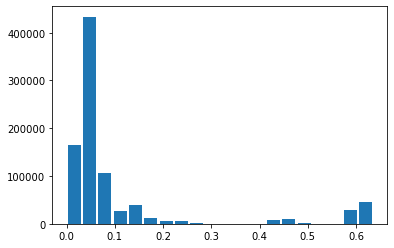

In [26]:
plt.hist(miss_percent_row,bins=20,rwidth=0.85,label=str);

In [28]:
# Here I count the rows having more than 30% of missing entries
rows_to_drop=[i for i in range(azdias.shape[0]) if miss_percent_row[i] > 0.3]
print(len(rows_to_drop))

93837


In [29]:
# Write code to divide the data into two subsets based on the number of missing values in each row.

# ANSWER 1
# First I should drop the rows I decided to omit from the database where I have already deleted the 6 columns with less
# than 20% of their entries (see section above) 
azdias_all_dropped = azdias_col_dropped.drop(index=rows_to_drop)
azdias_all_dropped.reset_index(drop=True,inplace=True)

In [30]:
# ANSWER 2 
# Second, I should build a database made just of the rows which have been taken away
# I will take these rows from the azdias_col_dropped database, so that in both final 
# databases with less than 891221 rows
# I will have the same number of columns; in particular, the longer one will be the database # to be used for good.
azdias_rows_to_drop = azdias_col_dropped.iloc[rows_to_drop,:]

In [31]:
azdias_col_dropped.shape[0]

891221

In [32]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# ANSWER 3:
# Since I have already dropped from both datasets the columns with >20% of missing entries,
# I can pick the first 5 columns of both of them and make the comparison
# To this end, let me write down a function which can make such a comparison after passing it the name of the column
# But first let me check that, for instance, the first columns 3-7 of the dataset qualify (they do)
# If we choose these, which are all categorical, we can use the .countplot() method to plot them all

for i in range(3,8):
    print(azdias_all_dropped.iloc[:,[i]].columns.values.item(),azdias_all_dropped.iloc[:,[i]].isna().sum().values[0]/azdias_col_dropped.shape[0])

FINANZ_MINIMALIST 0.0
FINANZ_SPARER 0.0
FINANZ_VORSORGER 0.0
FINANZ_ANLEGER 0.0
FINANZ_UNAUFFAELLIGER 0.0


In [33]:
def compare_distributions(column,dataset1,dataset2,datat1_desc,datat2_desc):
    plt.figure(figsize=[18,5])
    plt.subplot(1,2,1)
    plt.title(datat1_desc)
    sns.histplot(x=column, data=dataset1, stat='probability', discrete=True);
    
    plt.subplot(1,2,2)
    plt.title(datat2_desc)
    sns.histplot(x=column, data=dataset2, stat='probability', discrete=True);
    
    plt.subplots_adjust(wspace=0.5)
    plt.show()

With the function above, we can run a for loop over -for instance- all the ordinal variables in the dataset to gauge how many of them feature different distributions of data in the two row sets.

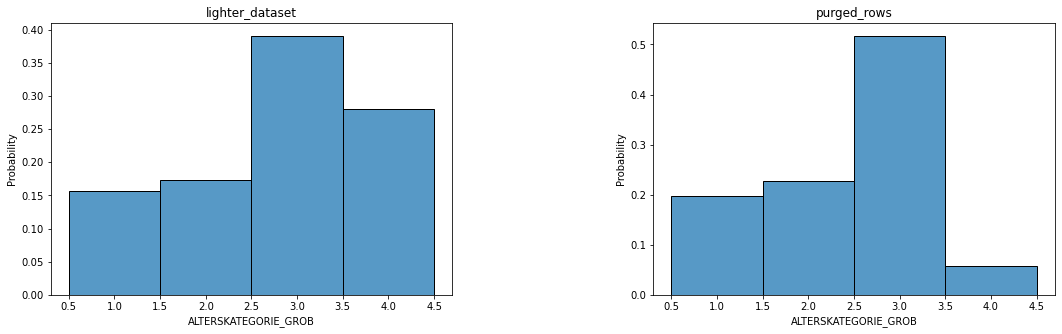

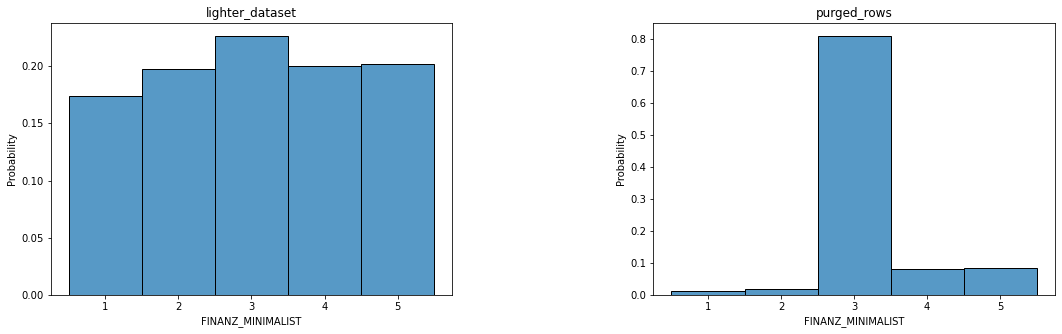

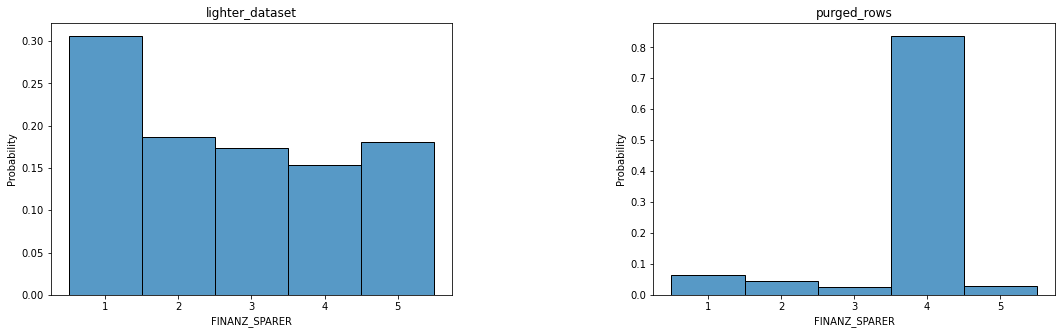

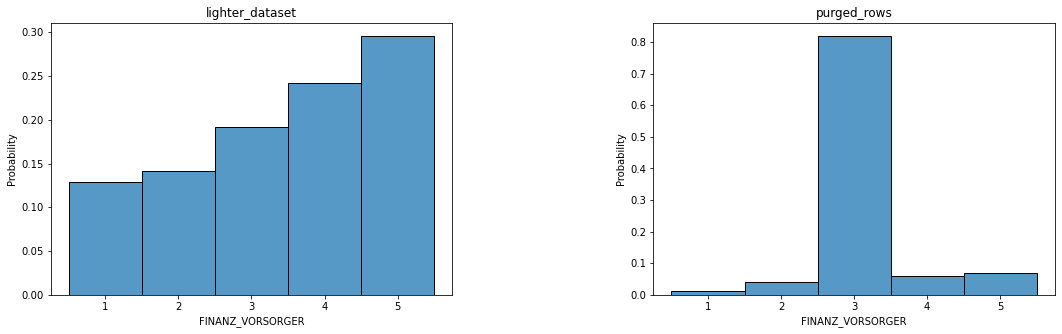

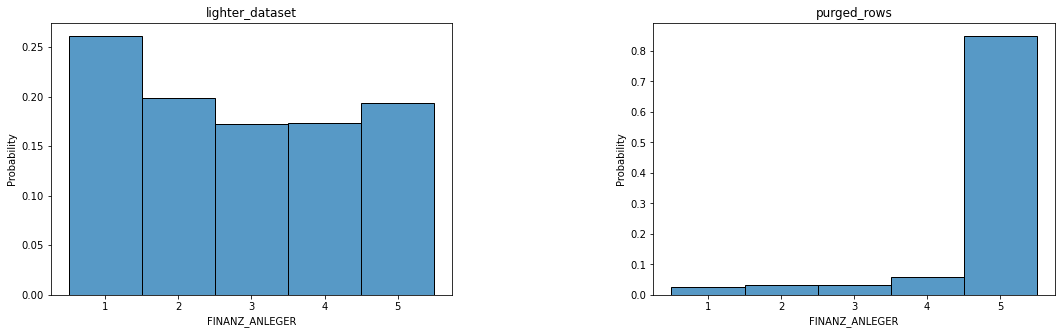

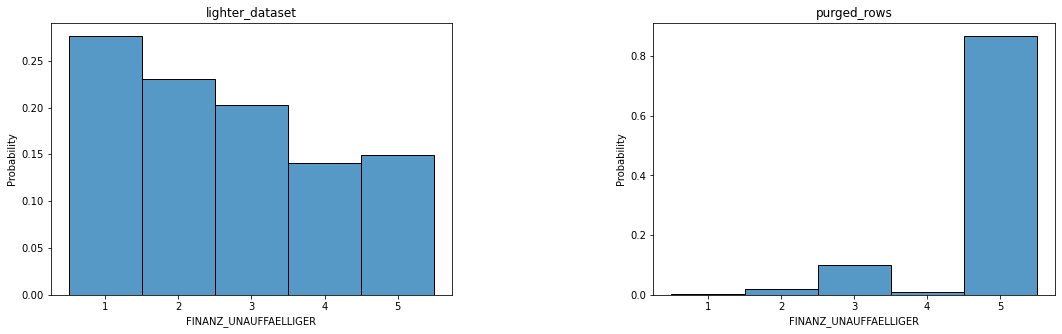

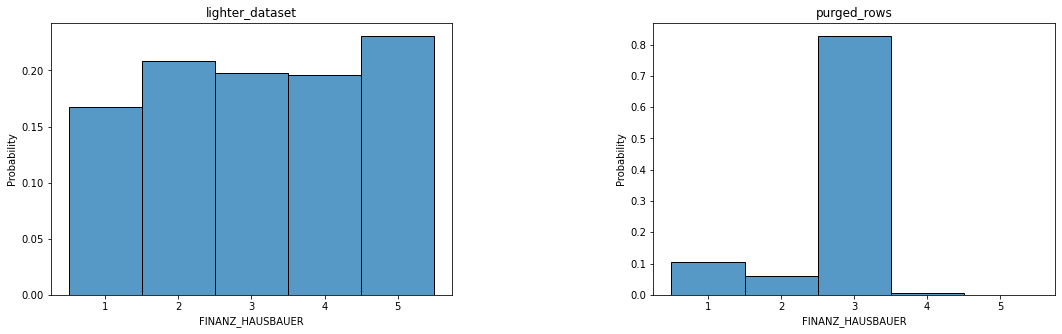

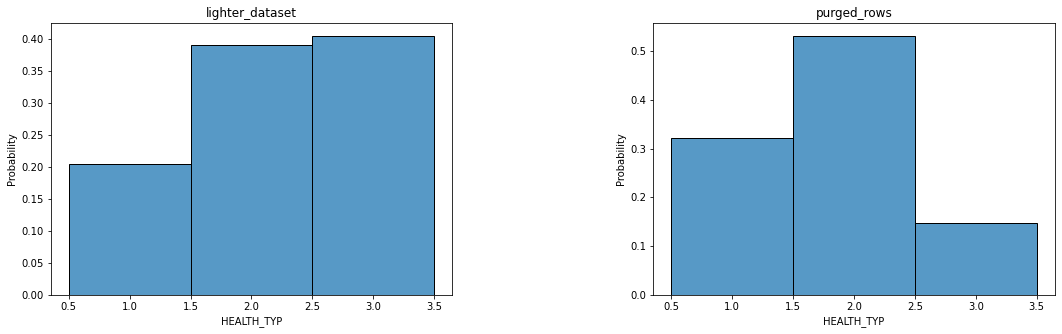

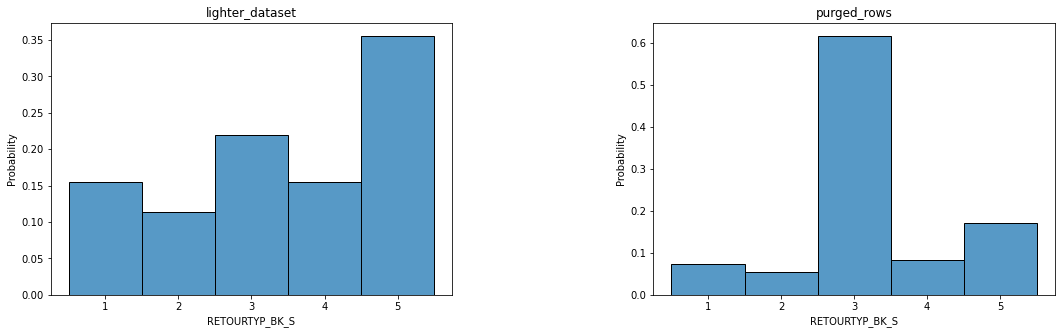

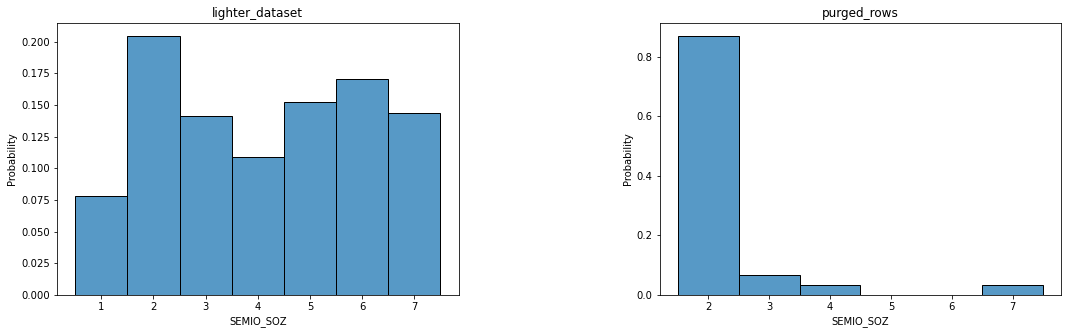

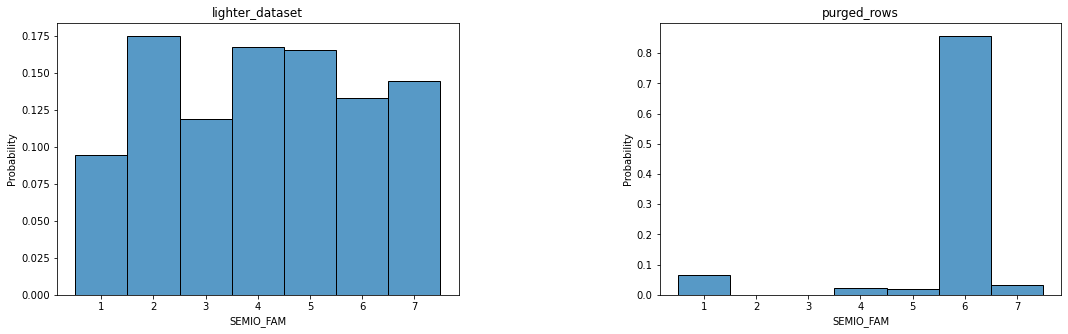

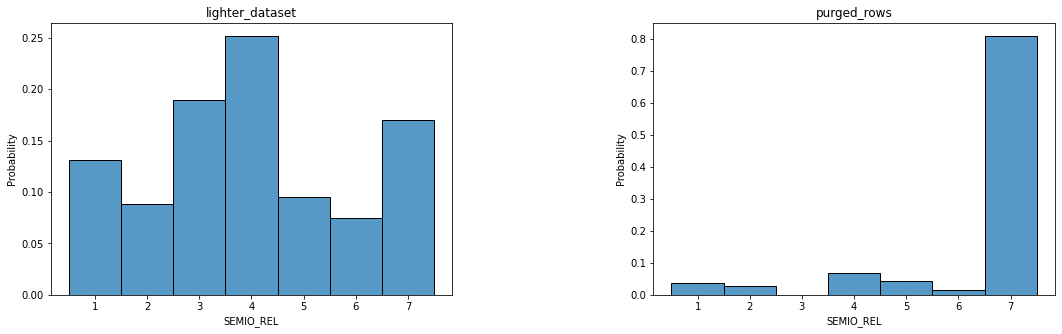

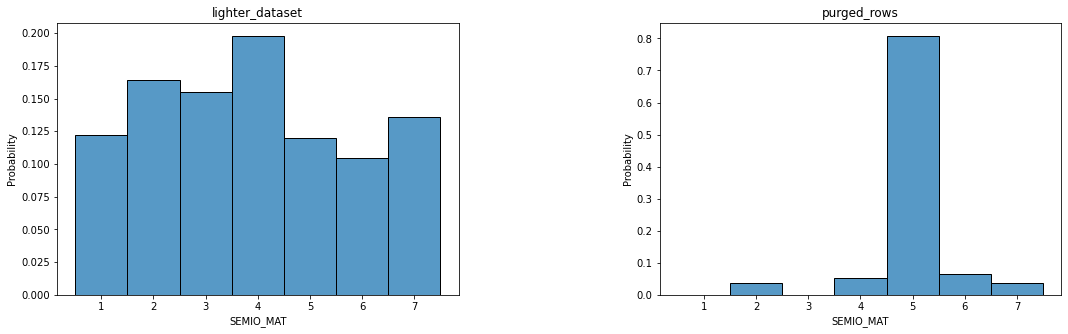

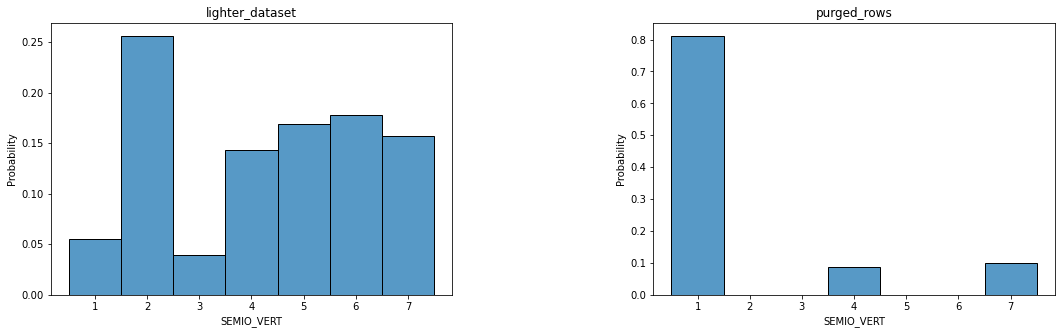

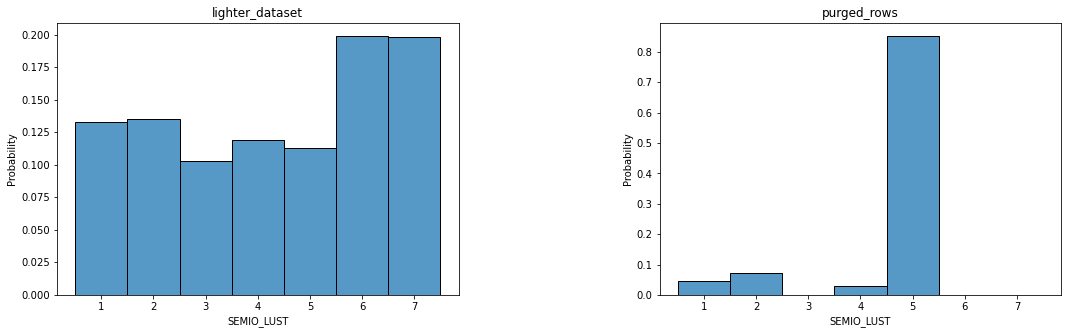

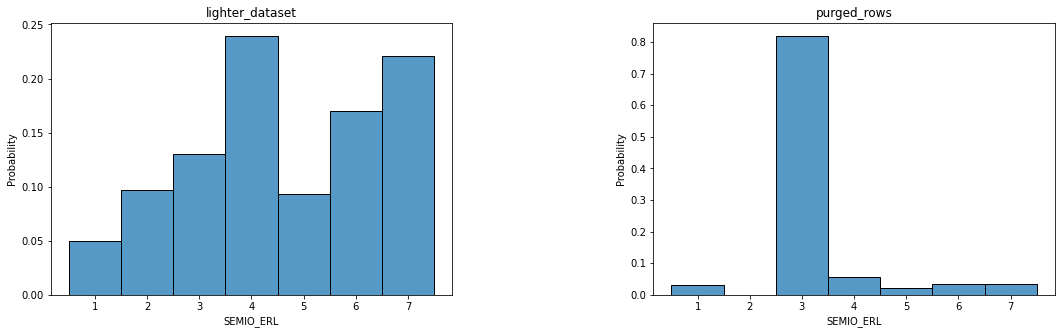

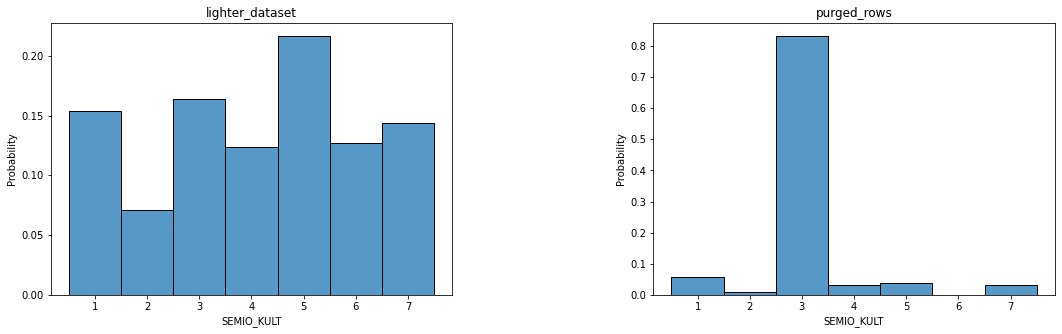

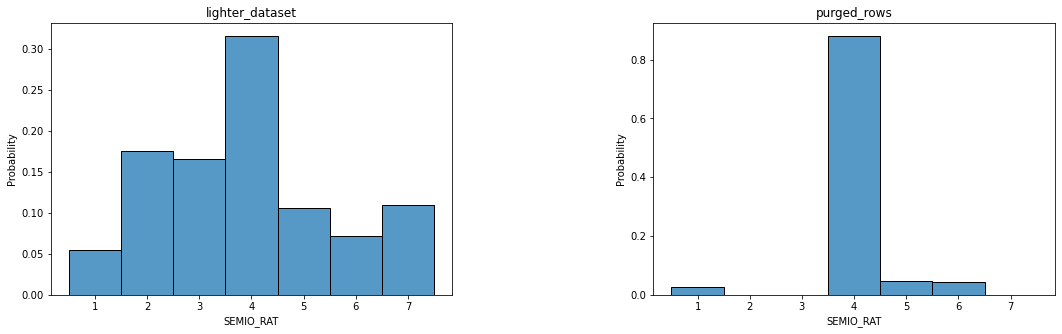

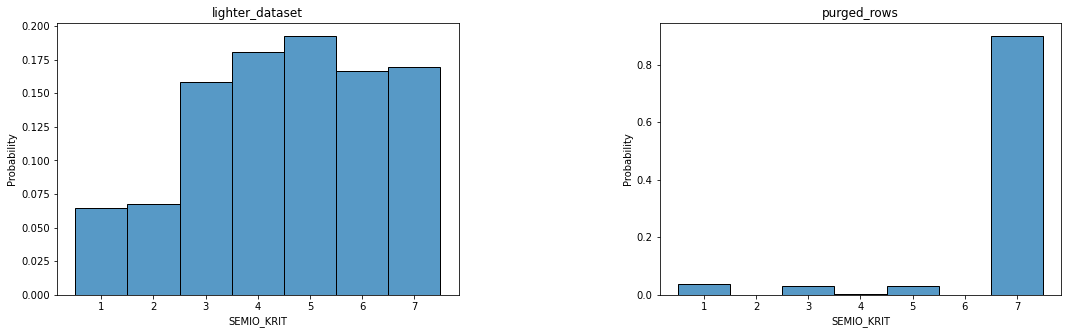

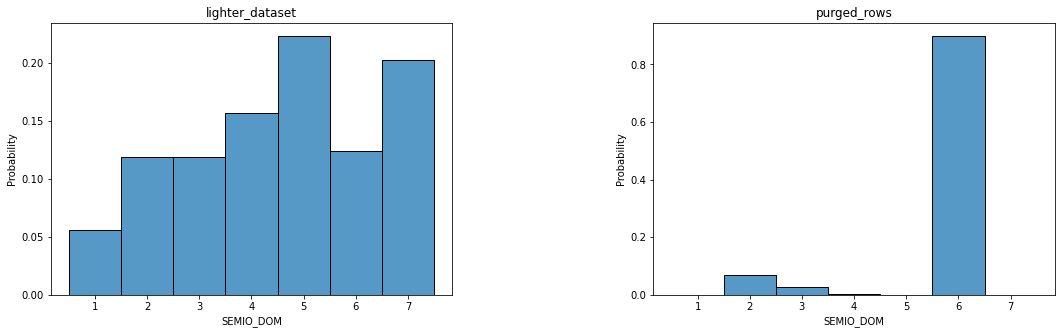

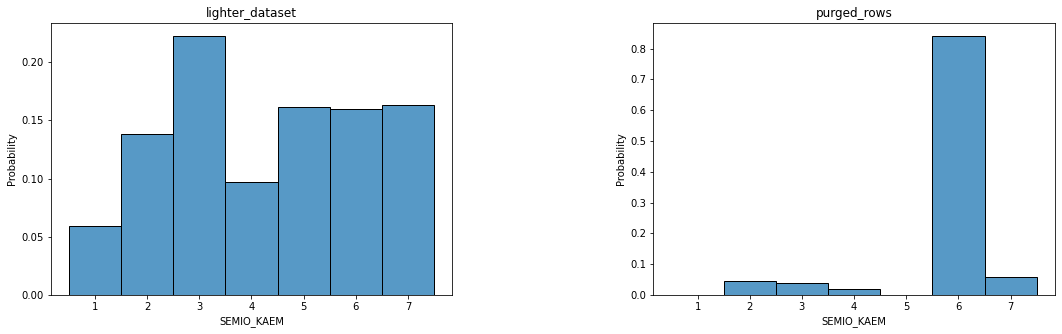

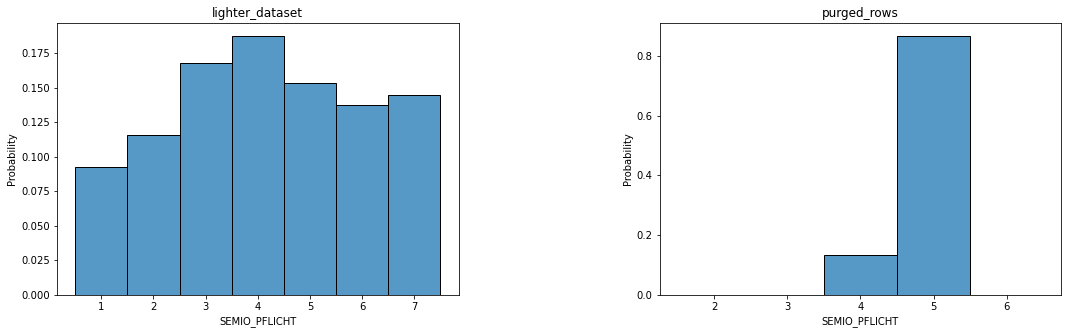

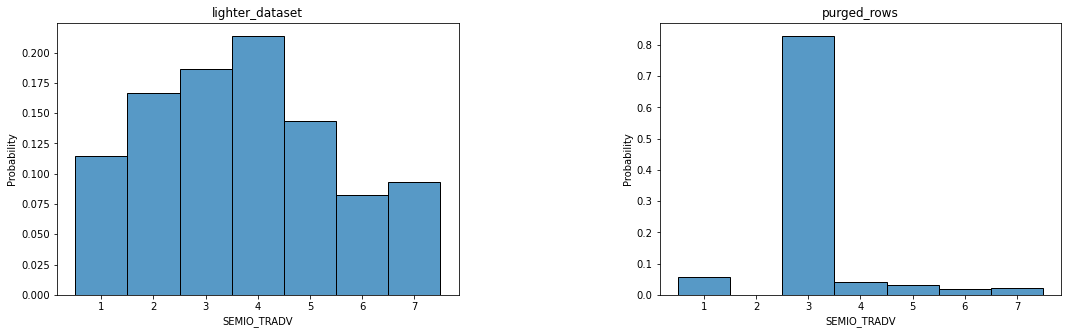

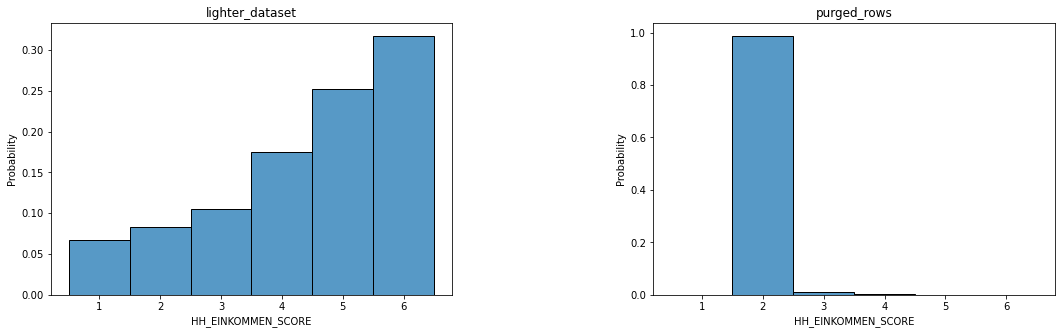

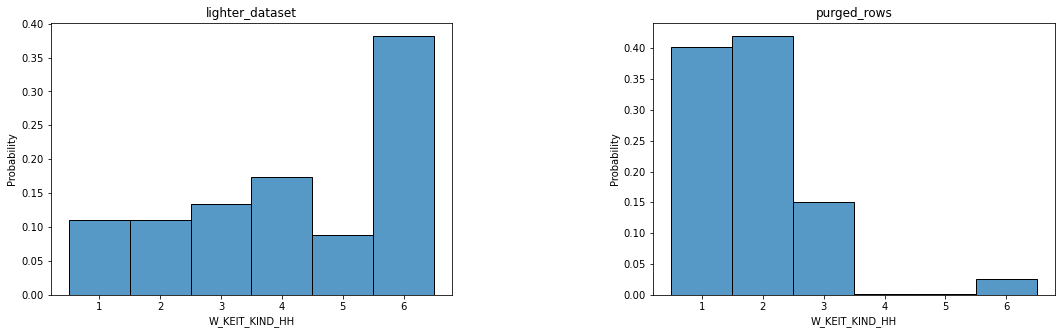

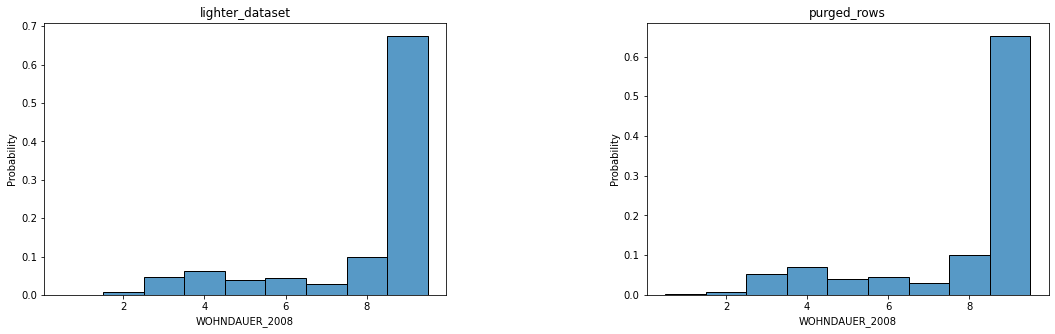

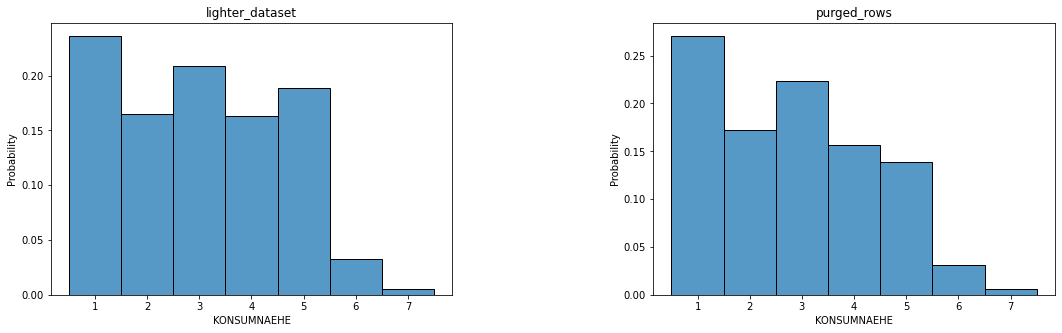

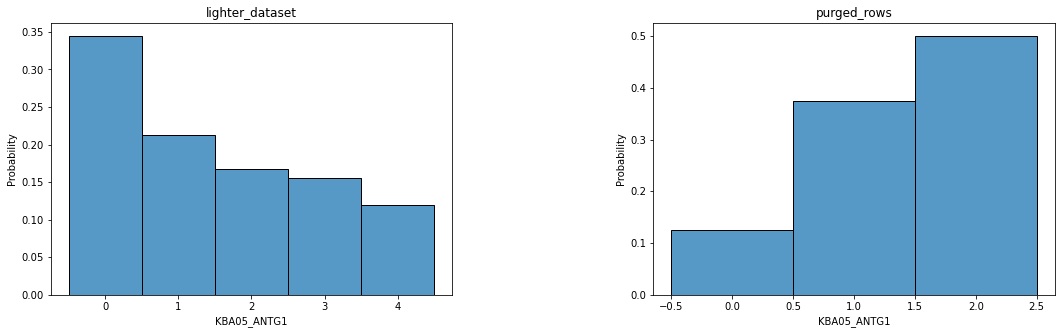

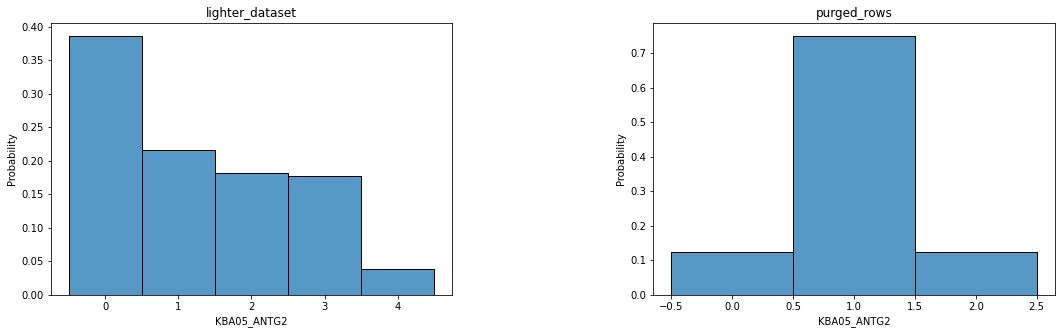

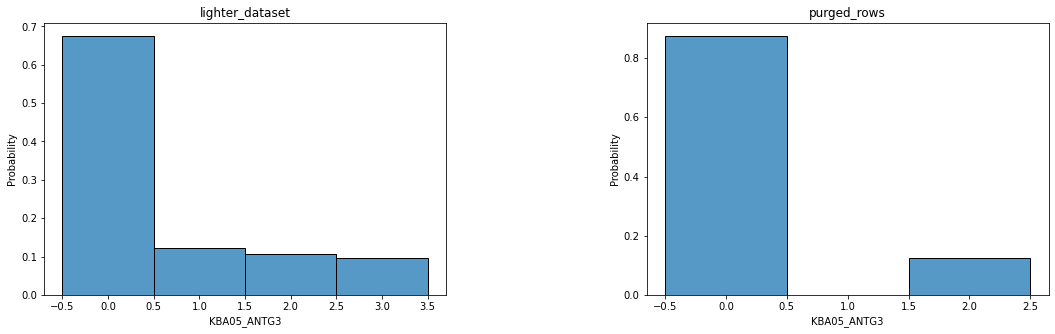

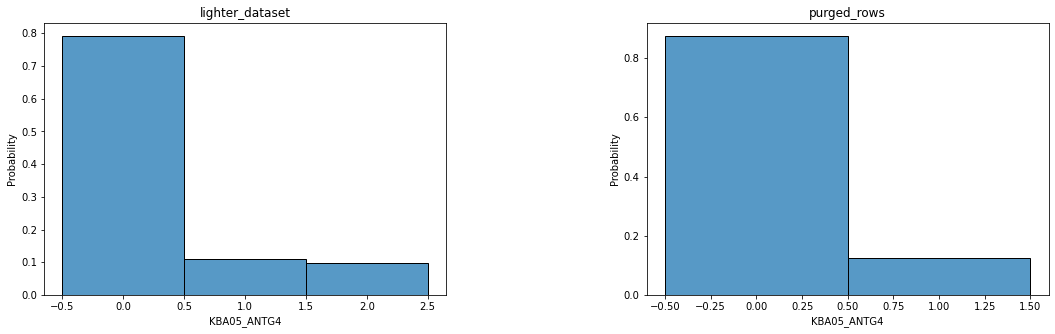

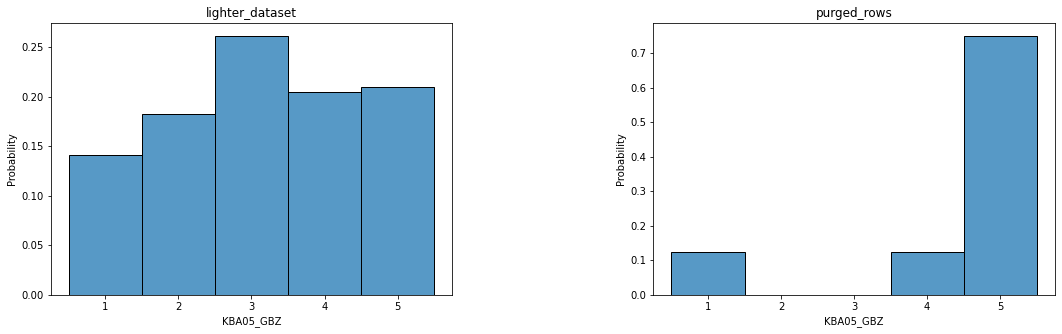

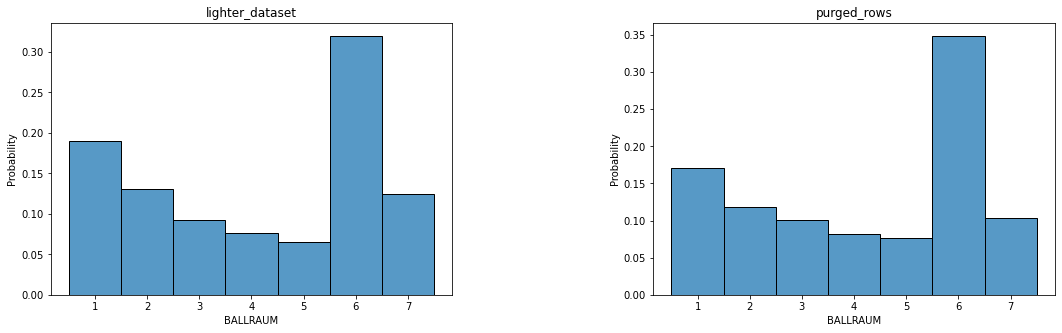

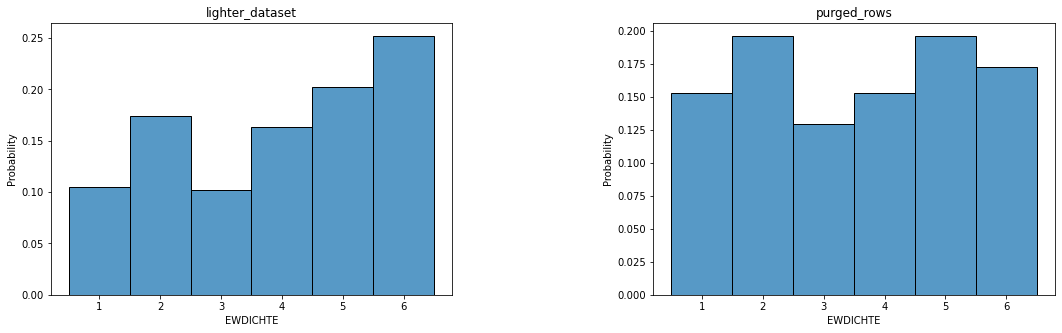

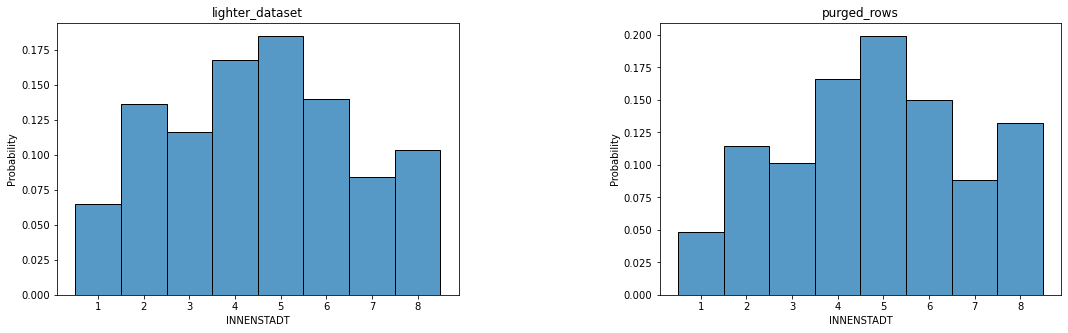

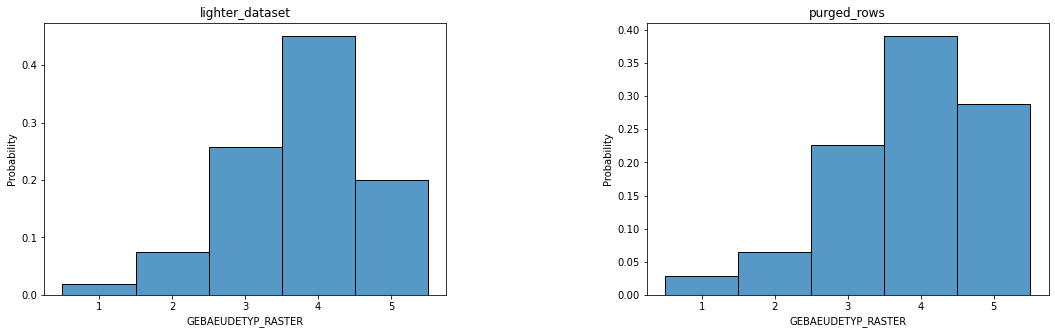

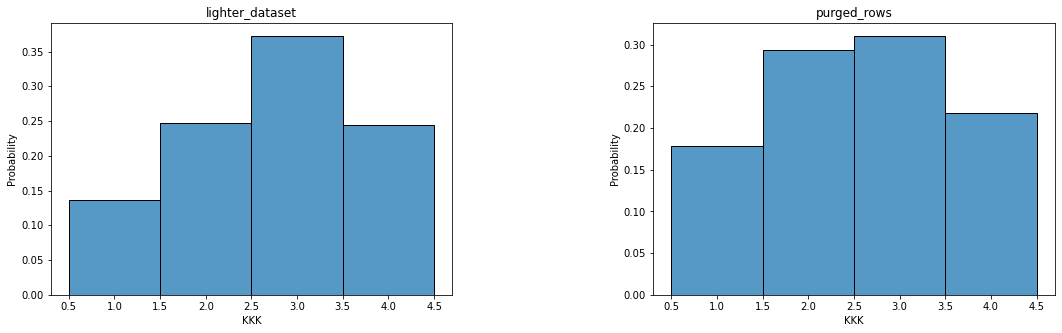

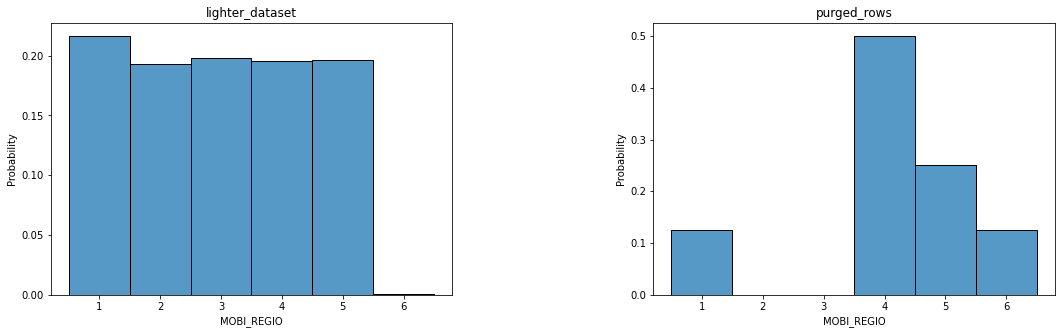

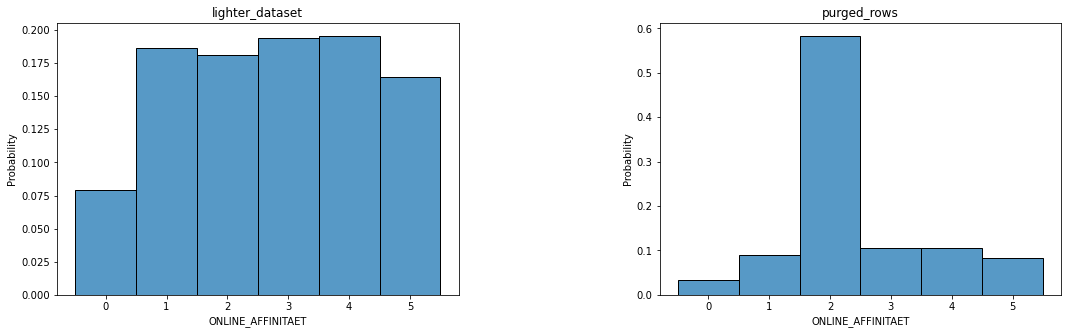

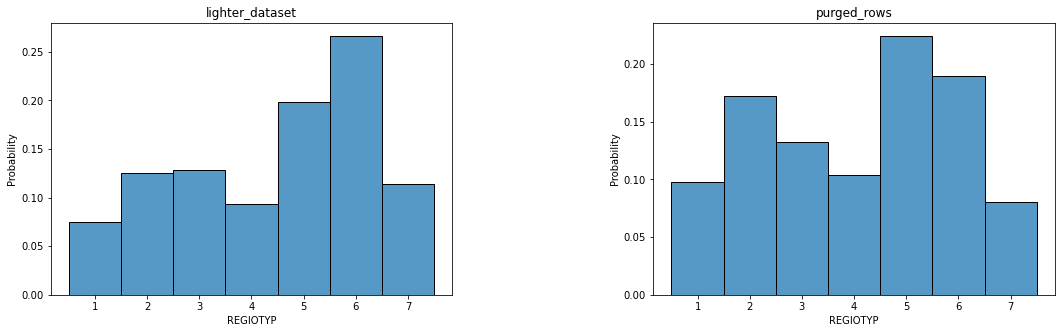

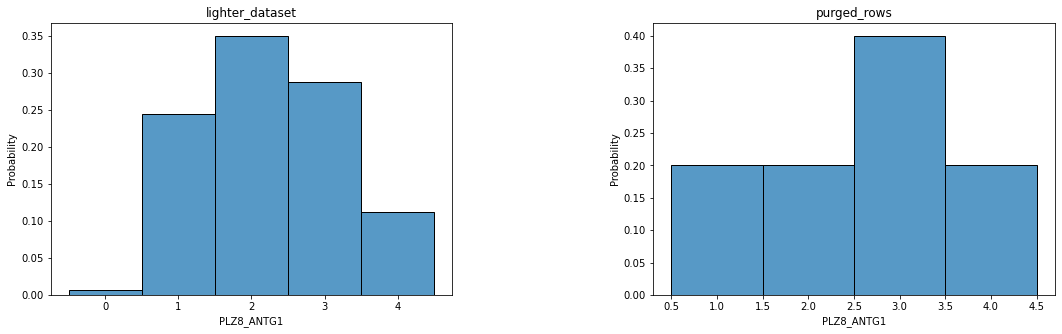

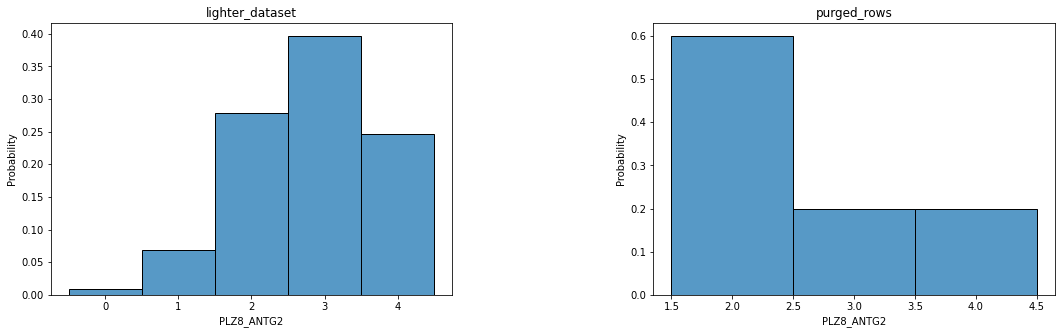

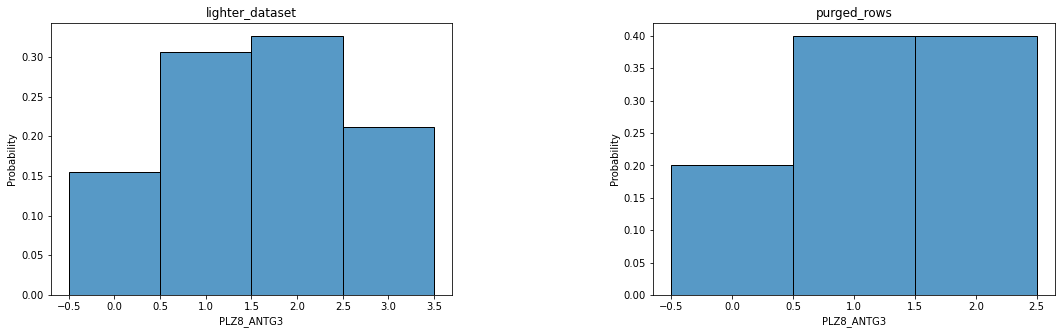

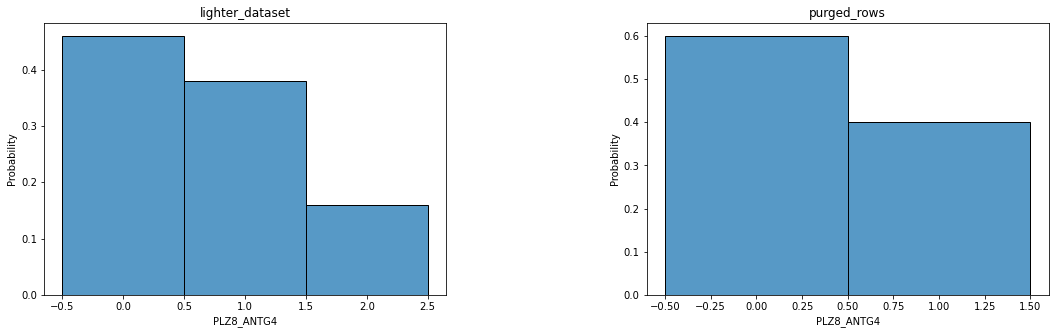

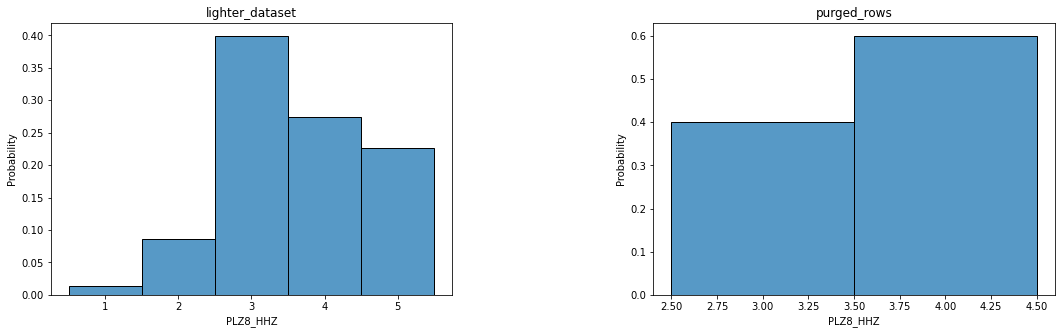

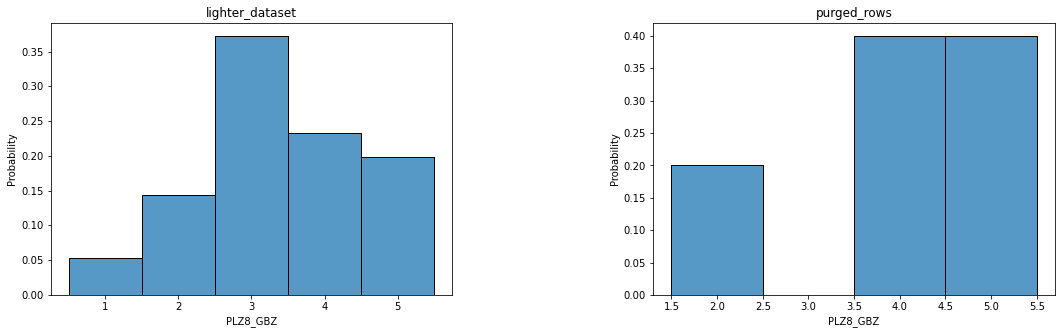

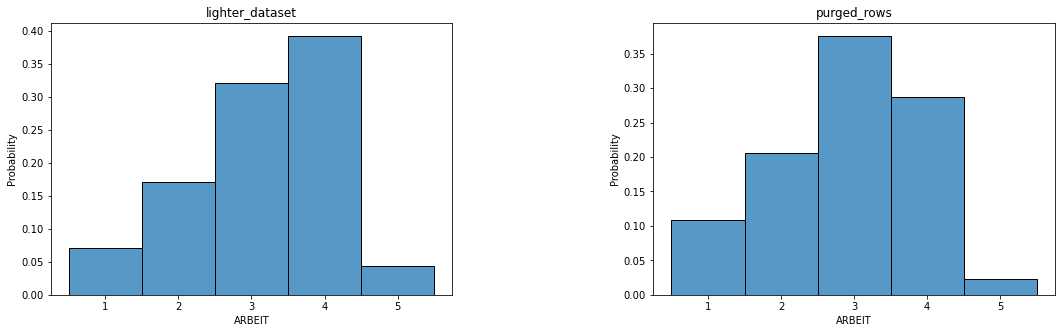

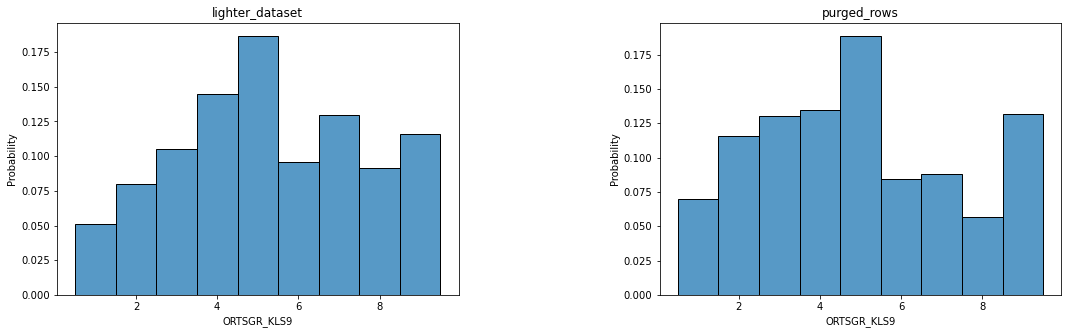

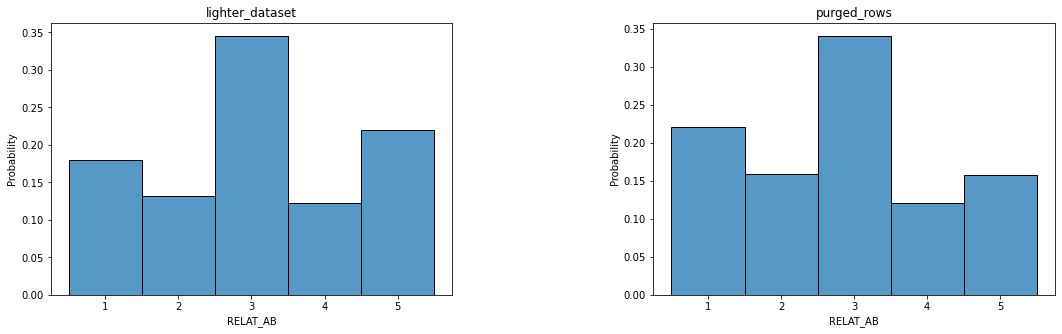

In [77]:
# ORDINAL VALUES

for i in range(79):
    if feat_info[feat_info['attribute']==azdias_all_dropped.iloc[:,[i]].columns.values.item()].type.item()=='ordinal':
        compare_distributions(azdias_all_dropped.iloc[:,[i]].columns.values.item(),azdias_all_dropped,azdias_rows_to_drop,'lighter_dataset','purged_rows')

#### Discussion 1.1.3: Assess Missing Data in Each Row

There are definitely variables for which the data distribution among the two sets of rows is quite similar.
But there are others where there is a blatant difference between the data in the rows we have kept and those in the rows we have omitted. The first ones which strike one's attention are financial situation indicators, starting with the second ordinal variables.

More specifically, we can see from the pair of histograms concerning the financial incospicousness of individuals in the dataset, that rows containing many missing data distinctively refer to individuals with significantly incospicuous financial status. 
Likely, these may not be the most interesting customers to focus a company's attention on.  


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [35]:
# I will first drop from feat_info the attributes that have been dropped from azdias
feat_info_all_dropped = feat_info.drop(index=col_to_drop)

In [36]:
# How many features are there of each data type ?
feat_info_all_dropped['type'].value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [37]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# The following shows the requested information:
# 'GEBAEUDETYP' is the binary variable which takes non numeric values

cat_idx=list(feat_info_all_dropped[feat_info_all_dropped['type']=='categorical']['attribute'].index)

for i in cat_idx:
    print(azdias_all_dropped[feat_info_all_dropped[feat_info_all_dropped['type']=='categorical']['attribute'][i]].value_counts())

2    415761
1    381623
Name: ANREDE_KZ, dtype: int64
4.0    198162
3.0    147137
2.0    141198
5.0    111057
6.0    101953
1.0     93237
Name: CJT_GESAMTTYP, dtype: int64
6    289018
1    196881
5    106267
2    104648
4     55891
3     44679
Name: FINANZTYP, dtype: int64
12.0    130067
10.0    102781
8.0      83012
11.0     75074
5.0      70477
4.0      60415
9.0      57078
3.0      53096
1.0      50649
2.0      43709
7.0      40655
6.0      25731
Name: GFK_URLAUBERTYP, dtype: int64
0    622212
1    175172
Name: GREEN_AVANTGARDE, dtype: int64
1.0     402323
10.0    128923
2.0      98523
11.0     48734
8.0      21778
7.0      19572
4.0      11574
5.0      11166
9.0      10452
6.0       8521
3.0       4685
Name: LP_FAMILIE_FEIN, dtype: int64
1.0    402323
5.0    188109
2.0     98523
4.0     49871
3.0     27425
Name: LP_FAMILIE_GROB, dtype: int64
1.0     206810
9.0     136296
10.0    111560
2.0     111033
4.0      73951
3.0      68904
6.0      28877
5.0      27507
8.0      18606
7.0    

In [38]:
# Here we create the lists by identifying the features which have more than 2 values
# and signing them up for encoding. 
# At the same time we identify those with 2 values which are not numerical and, therefore,
# need encoding as well. A more general code can be more naturally 
# incorporated into the general data-cleaning function requested above. 

need_encod=[];
no_need_encod=[];

for i in cat_idx:
    if len(azdias_all_dropped[feat_info_all_dropped[feat_info_all_dropped['type']=='categorical']['attribute'][i]].value_counts()) >2:
        need_encod.append(i)
    elif len(azdias_all_dropped[feat_info_all_dropped[feat_info_all_dropped['type']=='categorical']['attribute'][i]].value_counts()) == 2 and azdias_all_dropped[feat_info_all_dropped[feat_info_all_dropped['type']=='categorical']['attribute'][i]].dtype not in ['int64','float64']:
        need_encod.append(i)
    else: 
        no_need_encod.append(i)

# So the features with their index in the 'need_encod' list are up for OneHotEnconding

In [39]:
# Here is the list of feature labels to be encoded
to_be_encoded=list(feat_info_all_dropped[feat_info_all_dropped['type']=='categorical']['attribute'].drop(index=no_need_encod))

In [40]:
azdias_encoded = pd.get_dummies(azdias_all_dropped,columns=to_be_encoded)

#### Discussion 1.2.1: Re-Encode Categorical Features

So far, what I have decided to do has been to keep all categorical features. 
I have decided built a general-purpose routine which can be transferred right away 
to the data-cleaning function requested below. 

The data engineering steps performed so far have consisted in 

1. identifying the categorical variables

2. determining which variables need re-econding, either because they are not binary or because,
despite being binary, they are not numerical in nature;

3. using pd.get_dummies to one-hot-encode these variables and obtain the new dataset.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [41]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

In [42]:
# In order to create the binary variable out of 'PRAEGENDE_JUGENDJAHRE', we first set up
# lists, looking at the data dictionary, of the values corresponding to Mainstream or 
# Avantgarde
mainstream_entries=[1,3,5,8,10,12,14]
avantgarde_entries=[2,4,6,7,9,11,13,15]
# Next, we set up a list for the decades
decade_entries=[40,40,50,50,60,60,60,70,70,80,80,80,80,90,90]

In [43]:
# Youth decade function
def youth(obj,list):
    if pd.isnull(obj) == False:
        return list[int(obj)-1]

In [44]:
# Engineering the person's youth decade 
# (German translation courtesy of Google Translate)
azdias_encoded['JUGENDEKKADE']=azdias_encoded.PRAEGENDE_JUGENDJAHRE.apply(youth,args=(decade_entries,))

In [45]:
def movement(obj,mov_1,mov_2):
    if pd.isnull(obj) == False:
        if int(obj) in mov_1:
            return 0
        elif int(obj) in mov_2:
            return 1

In [46]:
# Engineering the person's ideological movement carachterising her youth 
# (German translation courtesy of Google Translate)
azdias_encoded['BEWEGUND']=azdias_encoded.PRAEGENDE_JUGENDJAHRE.apply(movement,args=(mainstream_entries,avantgarde_entries))

In [47]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables

# This is more immediate, it just boils down to separating decimal places
# Function to isolate the wanted decimal place and turn it into a number
def int_split(string,i):
    if pd.isnull(string)==False: 
        return string[i]


# German translation of wealth level and family structure courtesy of Google Translate 
azdias_encoded['REICHTUM']=azdias_encoded.CAMEO_INTL_2015.apply(int_split,args=(0,))
azdias_encoded['FAMILIENSTRUKTUR']=azdias_encoded.CAMEO_INTL_2015.apply(int_split,args=(1,))

In [48]:
feat_info_all_dropped[feat_info_all_dropped['type']=='mixed']

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


Now we must turn our attention to the remaining mixed type variables which are still left
and whose information we mean to keep (see section below for details).  
We start with WOHNLAGE, which stands for neighborhood quality.

In [49]:
# We have to engineer a new variable which flags the neighborhood as rural or not (1,2 vs 0)
# and distinguishes newer (2) from older houses (1) 
# Its value is NaN if the record was not taken

def rural_var(obj,list_1,list_2,list_3,list_4):
    if pd.isnull(obj) == False:
        if obj in list_1:
            return np.nan
        elif obj in list_2:
            return 0
        elif obj in list_3:
            return 1
        elif obj in list_4:
            return 2

# This is the new binary variable (German translation courtesy of Google Translate)
azdias_encoded['LÄNDLICHES_GEBIET']=azdias_encoded.WOHNLAGE.apply(rural_var,args=([0],[1,2,3,4,5],[7],[8]))

In [50]:
# And this is the second new variable, which is NaN if the quality of the home is not measured
# or if the latter is in a rural area, otherwise it keeps the 5 ordinal values for the urban
# classification

def neigh_qual(obj,list_1,list_2):
    if obj in list_1:
        return obj
    elif obj in list_2:
        return np.nan

# This is a variable detailing the urban neighborhood quality, which is NaN if the data was not retrieved or if the area is rural 
azdias_encoded['NACHBARSCHAFTSQUALITÄT']=azdias_encoded.WOHNLAGE.apply(neigh_qual,args=([1,2,3,4,5],[0,7,8]))

Now is the turn of PLZ8_BAUMAX, a variable which we also want to split into two new variables: a binary variable to tell business area from residential areas and the other one to distinguish the four remaining categories of residential areas based on the most common range of numbers of families living within the microcell. 

In [51]:
azdias_encoded['PLZ8_BAUMAX'].value_counts()

# This is a trivial function to create the binary variable
def binary_business(obj,list_1,list_2):
    if obj in list_1:
        return 0
    elif obj in list_2:
        return 1

azdias_encoded['GESCHÄFTSBEREICH']=azdias_encoded.PLZ8_BAUMAX.apply(binary_business,args=([1,2,3,4],[5]))

# Here come another simple function to create the categorical variable 
# in the event that the area is residential

def fam_num(obj,list_1,list_2):
    if obj in list_1:
        return obj
    elif obj in list_2:
        return 0

azdias_encoded['GANZAHL_DER_FAMILIEN']=azdias_encoded.PLZ8_BAUMAX.apply(fam_num,args=([1,2,3,4],[5]))

In [52]:
# Here I remove the other 6 mixed type variables which I must not keep any longer
# either because I have engineered new features (first 4) or because I have dropped them (last 2)
# Dropping them all in the same line of code allows me to make sure they are not left 

azdias_encoded.drop(columns=['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015','WOHNLAGE','PLZ8_BAUMAX','LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB'],inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

As for 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015', I performed exactly the steps required in the assignment above.

This leaves 4 more mixed type features among those with sufficient data, namely

- LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB, i.e.
  fine grained or more coarse aggregated information about life stage and weath of people.
  I decided to drop these two: first of all, they contain a lot of redundant information: 
  for instance, people's wealth is recorded in
  CAMEO_INTL_2015, which we have already disentangled.

- WOHNLAGE, i.e. neighborhood quality or rural flag and I decided to add a binary variable
  which carachterizes the neighborhood ar rural or not, while keeping the remaining
  information within another variable for city households.

- PLZ8_BAUMAX, i.e. most common number of families within one building or business buildings,
  led me to a similar choice: I created a new binary variable which charachterizes the area
  as business area or not and kept the remaining information about the most common number of families
  in any given building within the microcell in another variable.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [53]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

#Looking at the mixed type fetures which had survived to data dropping due to an excess of missing values,
# we can see below that the 6 mixed type features have been takien care of above 

feat_info_all_dropped[feat_info_all_dropped['type']=='mixed']

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [54]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# I can create a new feature summary which does not see them and includes, on the other hand,
# the newly created variables
feat_info_all_dropped_nomixed=feat_info_all_dropped.drop(index=[15,16,22,56,59,79])

# I can create a new database with the 8 newly engineered features

feat_info_new_mixed = {
'attribute' : ['JUGENDEKKADE','BEWEGUND','REICHTUM','FAMILIENSTRUKTUR','LÄNDLICHES_GEBIET','NACHBARSCHAFTSQUALITÄT','GESCHÄFTSBEREICH','GANZAHL_DER_FAMILIEN'],
'information_level': ['person','person','microcell_rr4','microcell_rr4','building','building','microcell_plz8','microcell_plz8'] ,
'type': ['categorical','categorical','categorical','categorical','categorical','categorical','categorical','categorical'],
'missing_or_unknown': [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]
}

new_feat = pd.DataFrame(feat_info_new_mixed)

feat_info_final = feat_info_all_dropped_nomixed.append(new_feat)

In [55]:
# Now I should check that the number of features I have dropped initially plus the 6 mixed type ones I have re-engineered minus the 8 new ones is equal to the difference between the rows of feat_info and feat_info_final

feat_info.shape[0]-feat_info_final.shape[0]-(len(col_to_drop)+6-8)

0

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. 

In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [56]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    
    # remove selected columns and rows, ...

    
    # select, re-encode, and engineer column values.

    
    # Return the cleaned dataframe.
    return df

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [76]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and do that now.
# We see that 39% (> every third) of data features some missing values. 
# Simply removing them is definitely going to bias estimates of some parameters,
# so outright deleting rows with missing values is not the way forward

azdias_encoded.shape[0], azdias_encoded.isna().any(axis=1).sum(), azdias_encoded.isna().any(axis=1).sum()/azdias_encoded.shape[0]

(797384, 311116, 0.3901708587079751)

In [90]:
# As we can see, in the vast majority of rows there are no or very few missing values. 
azdias_encoded.isna().sum(axis=1).value_counts()

0     486268
1     160308
2      40105
3      32708
4      15598
5      10435
9       9618
6       8359
8       8090
10      4805
7       4699
18      2638
16      2307
17      2197
15      2089
14      1942
11      1513
19      1302
12       811
21       694
13       444
20       400
22        34
23        19
24         1
dtype: int64

In [95]:
azdias_encoded.shape[0]

797384

In [123]:
# As we can see, in all columns the percentage of missing data is really negligible: 
# below one can see that columns with many missing values are rare (actually, only one has # an order of magnitude of missing values comparabe to the umber of rows)
# Therefore, using an imputer which replaces missing with most frequent values 
# on the azdias_encoded dataset is fine
azdias_encoded.isna().sum(axis=0).value_counts()

0         158
22683       8
39495       6
591         3
4640        2
5951        2
28381       2
36427       2
4222        2
64401       2
193371      1
3730        1
6726        1
69          1
6331        1
12236       1
4121        1
58898       1
6           1
2785        1
dtype: int64

In [157]:
# So here we apply the imputer to our dataframe
imp_most=SimpleImputer(missing_values=np.nan,strategy='median')
azdias_imputed=imp_most.fit_transform(azdias_encoded)

In [160]:
# Apply feature scaling to the general population demographics data.
std_scal=StandardScaler(with_mean=True,with_std=True)
azdias_scaled=std_scal.fit_transform(azdias_imputed)

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [59]:
# Apply PCA to the data.



In [60]:
# Investigate the variance accounted for by each principal component.



In [61]:
# Re-apply PCA to the data while selecting for number of components to retain.



### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [62]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.



In [63]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.



In [64]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.



### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [65]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
    
    

In [66]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.



In [67]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.



### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [68]:
# Load in the customer demographics data.
customers = 

SyntaxError: invalid syntax (<ipython-input-68-416d584d1460>, line 2)

In [ ]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.



### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.



In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?



In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?



### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.